In [13]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [12]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2025-05-14 01:49:45--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.2’

cats_and_dogs.zip.2 100%[===================>]  67.43M  62.8MB/s    in 1.1s    

2025-05-14 01:49:46 (62.8 MB/s) - ‘cats_and_dogs.zip.2’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
# 3
# Generadores para preprocesamiento
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Data generators
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# OJO: test_dir NO tiene subcarpetas, así que hay que mover las imágenes a una carpeta "test" interna
# Si ya lo hizo el notebook, esto funcionará:
test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=PATH,  # raíz
    shuffle=False,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode=None,
    classes=['test']
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


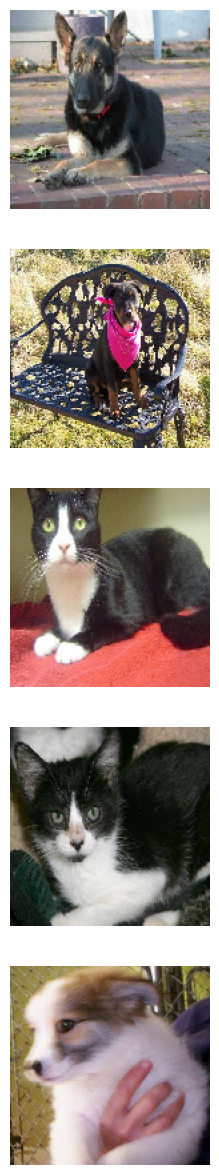

In [15]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [16]:
# Haciendo Data augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,         # Rota la imagen aleatoriamente en un ángulo de hasta 40°
    width_shift_range=0.2,     # Desplaza horizontalmente hasta el 20%
    height_shift_range=0.2,    # Desplaza verticalmente hasta el 20%
    shear_range=0.2,           # Corta la imagen en diagonal
    zoom_range=0.2,            # Aplica zoom aleatorio
    horizontal_flip=True,      # Invierte la imagen horizontalmente
    fill_mode='nearest'        # Rellena los pixeles vacíos tras la transformación
)

Found 2000 images belonging to 2 classes.


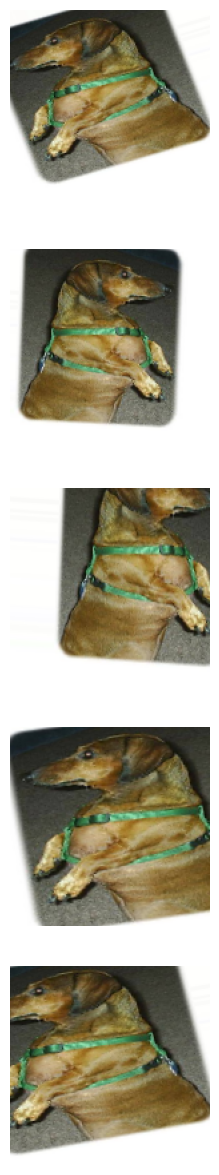

In [17]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [31]:
# 7
model = Sequential([
    # Primer bloque convolucional
    Conv2D(32,(3,3),activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(pool_size=(2,2)),
    # Segundo bloque convolucional
    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Tercer bloque convolucional
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Aplanar y pasar a densa
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')  # Solo 1 salida: 0 = gato, 1 = perro

])
# Le dice al modelo como debe aprender
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# 8
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val
)


Epoch 1/15
  16/2001 ━━━━━━━━━━━━━━━━━━━━ 4:25:28 8s/step - accuracy: 0.4851 - loss: 1.0590

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2001/2001 ━━━━━━━━━━━━━━━━━━━━ 151s 69ms/step - accuracy: 0.4949 - loss: 0.8603 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 2/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 133s 62ms/step - accuracy: 0.5259 - loss: 0.6908 - val_accuracy: 0.5000 - val_loss: 0.6964
Epoch 3/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 134s 63ms/step - accuracy: 0.5269 - loss: 0.6900 - val_accuracy: 0.6180 - val_loss: 0.6723
Epoch 4/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 133s 63ms/step - accuracy: 0.5756 - loss: 0.6776 - val_accuracy: 0.5710 - val_loss: 0.6550
Epoch 5/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 145s 69ms/step - accuracy: 0.5841 - loss: 0.6691 - val_accuracy: 0.5680 - val_loss: 0.6504
Epoch 6/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 133s 61ms/step - accuracy: 0.5836 - loss: 0.6641 - val_accuracy: 0.6370 - val_loss: 0.6509
Epoch 7/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 133s 61ms/step - accuracy: 0.5579 - loss: 0.6733 - val_accuracy: 0.5970 - val_loss: 0.6392
Epoch 8/15
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 141s 62ms/step - accuracy: 0.6061 - lo

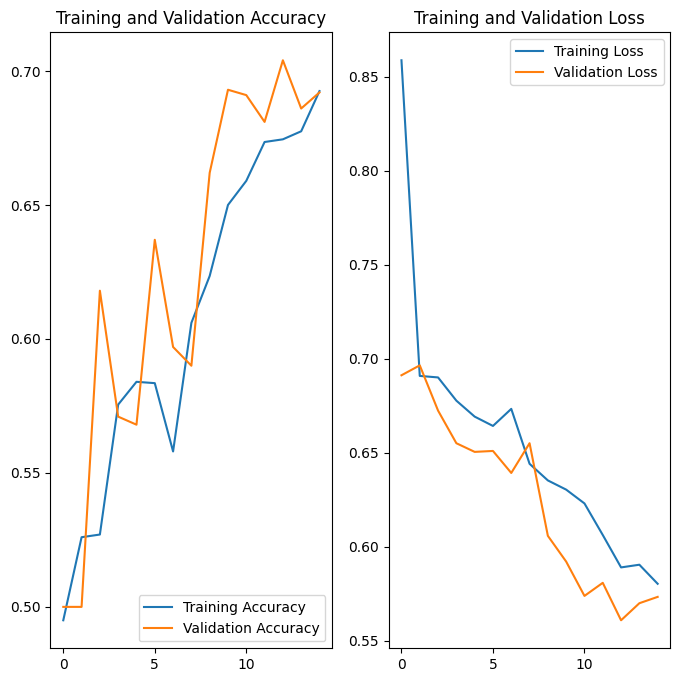

In [33]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")